# Painting style recognition from images

We will evaluate linear regression, without and with feature expansion, kernel regression and kernel SVM on the task of painting style recognition from images. In the SVM case, we will make use of scikit-learn.

We will use a subset of the wikiart dataset of Tan et al., A Deep Convolutional Network for Fine-art Paintings Classification, ICIP 2016. This subset consists of 64x64 images of paintings of 8 different styles (Abstract-Expressionism, Art-Nouveau Modern, Baroque, Color Field Painting, Cubism, Early Renaissance, Expressionism, High Renaissance). There are between 1343 and 2782 examples per class. I precomputed features (Histogram of Oriented Gradient) from the images. The data is given in two parts (because of Moodle size limitations). Each part contains:
- X: the feature vector for each image
- Y: the label of each image

Let us first load the data

In [1]:
import numpy as np
import scipy.io as sio # This will allow us to load the data
data = sio.loadmat('wikiart_data/wikiart_data_1.mat')
X1 = data['X1']
Y1 = data['Y1']
data = sio.loadmat('wikiart_data/wikiart_data_2.mat')
X2 = data['X2']
Y2 = data['Y2']
X = np.vstack((X1,X2))
Y = np.vstack((Y1,Y2))

print(X.shape)
print(Y.shape)

(15366, 1764)
(15366, 1)


Let us visualize the first image of each class

In [2]:
import matplotlib.pyplot as plt
import os

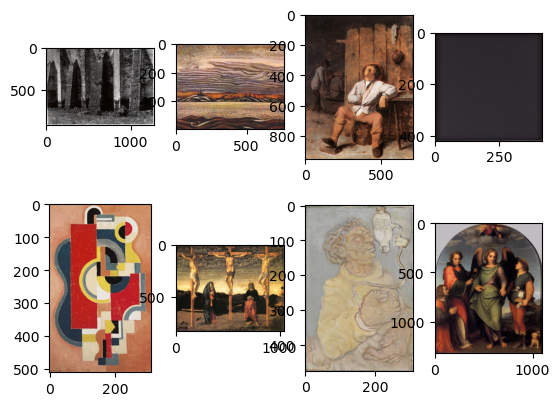

In [3]:
f, ax = plt.subplots(2, 4)
os.chdir('wikiart_samples')
for i in range(0,2):
    for j in range(0,4):
        dirnum = i*4+j+1
        os.chdir(str(dirnum))
        name = os.listdir()
        img = plt.imread(name[0])
        ax[i,j].imshow(img)
        os.chdir('..')
os.chdir('..')
plt.show()

We can then separate the data between training and test samples. To this end, we will make use of the scikit-learn train_test_split function, and keep one third of the data as test data.

In [4]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size=0.33,random_state=1)
Ytrain = Ytrain.squeeze()
Ytest = Ytest.squeeze()
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(10295, 1764)
(5071, 1764)
(10295,)
(5071,)


Let us compute one-hot encodings of the training labels

In [5]:
Ytrain_oh = np.zeros((Ytrain.shape[0],8))
Ytrain_oh[(np.arange(Ytrain_oh.shape[0]),Ytrain.flatten()-1)] = 1
print(Ytrain_oh.shape)
print(Ytrain.flatten())
print(Ytrain.flatten()-1)
print(Ytrain_oh)

(10295, 8)
[7 6 3 ... 7 1 7]
[6 5 2 ... 6 0 6]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


## Linear regression

Let us first look at linear regression for a linear baseline. The first thing to do is to add a 1 to the inputs to account for the bias

In [6]:
Xbtrain = np.hstack((np.ones((Xtrain.shape[0],1)),Xtrain))
Xbtest = np.hstack((np.ones((Xtest.shape[0],1)),Xtest))
print(Xbtrain.shape)

(10295, 1765)


 Then, we can compute the optimal parameter matrix W

In [7]:
M = np.linalg.pinv(Xbtrain)
W = M@Ytrain_oh
print(W.shape)

(1765, 8)


From these weights, we can compute the predicted class score vectors, and convert them to labels

In [8]:
Yhat_oh = Xbtest@W
Yhat = np.argmax(Yhat_oh,axis=1)+1

Then, we can compute the confusion matrix and the accuracy

In [9]:
import sklearn.metrics as skm
cmat = skm.confusion_matrix(Ytest,Yhat)
cmat

array([[316, 129,  85, 107, 138,  32,  88,  31],
       [157, 163,  82,  27,  87,  33,  82,  26],
       [109,  67, 259,   7,  71,  28,  53,  38],
       [ 71,  30,  17, 342,  31,  12,  27,   3],
       [170,  85,  75,  47, 188,  33, 112,  29],
       [108,  59,  61,  21,  56,  92,  48,  40],
       [144,  94,  94,  28, 104,  23, 148,  37],
       [ 62,  48,  96,   8,  45,  58,  58,  52]], dtype=int64)

In [10]:
np.diag(cmat).sum()/cmat.sum()

0.307631630842043

## Feature expansion

We will now look into expanding the features. To this end, we will consider quadratic expansion, but, because of the size of the input, we will limit ourselves to the squares of individual variables (i.e., we will not consider products of the form $x_i^{(j)}x_i^{(k)}$). Note that we will still use the original features in addition to the quadratic ones. Let us first compute the expanded features

In [11]:
Phitrain = np.hstack((Xtrain,Xtrain**2))
Phitest = np.hstack((Xtest,Xtest**2))
Phibtrain = np.hstack((Phitrain,np.ones((Phitrain.shape[0],1))))
Phibtest = np.hstack((Phitest,np.ones((Phitest.shape[0],1))))
print(Phibtrain.shape)
print(Phibtest.shape)

(10295, 3529)
(5071, 3529)


We can then again apply linear regression to the resulting features

In [12]:
M = np.linalg.pinv(Phibtrain)
W = M@Ytrain_oh
Yhat_oh = Phibtest@W
Yhat = np.argmax(Yhat_oh,axis=1)+1

Then, we can compute the confusion matrix and the accuracy

In [13]:
cmat = skm.confusion_matrix(Ytest,Yhat)
cmat

array([[275, 127,  77,  81, 161,  50, 105,  50],
       [131, 159,  78,  24,  93,  45,  83,  44],
       [112,  63, 230,   3,  77,  43,  68,  36],
       [ 92,  33,  24, 275,  46,  19,  31,  13],
       [154,  83,  69,  33, 200,  43, 109,  48],
       [ 80,  54,  63,  13,  64, 103,  53,  55],
       [147,  92,  87,  28, 113,  39, 128,  38],
       [ 58,  56,  91,   4,  59,  48,  54,  57]], dtype=int64)

In [14]:
np.diag(cmat).sum()/cmat.sum()

0.2814040623151252

This is disappointing: It means that, with the additional features, the model is able to better fit to the training data, without generalizing to the test data (you can see this by evaluating the trained models on the training data instead of the testing one). This is a case of "overfitting", which we will discuss next week. Feel free to experiment with other expansion strategies, such as higher polynomial degrees and sine/cosine functions, to see if you can improve this result.

## Kernel regression

Let us now look at kernel regression for classification. We will try with both a quadratic polynomial kernel and an RBF one. Let us start with the polynomial one. First, we need to compute the kernel matrices (training and test). To this end, make use of the data augmented with the additional 1. Note that the quadratic kernel is not equivalent to our previous quadratic feature expansion, because it implicitly encompasses all pairwise products between the variables.

In [15]:
K = (Xbtrain@Xbtrain.T)**2
Kt = (Xbtrain@Xbtest.T)**2
print(K.shape)
print(Kt.shape)

(10295, 10295)
(10295, 5071)


We can then compute the scores for the test data and convert them into labels. Note that, in practice, the kernel matrix is quite large, and is therefore likely to have low rank and thus not be invertible. To overcome this, we can add a small value, e.g., 1e-3, on its diagonal. This may seem like a heuristic but is in fact justified, as we will discuss next week during the lecture.

In [16]:
Yhat_oh = Kt.T@np.linalg.inv(K+1e-3*np.identity(Xtrain.shape[0]))@Ytrain_oh
Yhat = np.argmax(Yhat_oh,axis=1)+1

Compute the confusion matrix and the accuracy

In [17]:
cmat = skm.confusion_matrix(Ytest,Yhat)
cmat

array([[406, 115,  61,  75, 126,  46,  63,  34],
       [166, 214,  67,  14,  67,  33,  67,  29],
       [ 84,  65, 319,   3,  39,  19,  63,  40],
       [104,  27,  15, 302,  34,  16,  25,  10],
       [138,  98,  54,  14, 223,  42, 121,  49],
       [ 88,  46,  45,   7,  58, 147,  42,  52],
       [158,  89,  63,   9,  93,  39, 173,  48],
       [ 60,  52,  70,   1,  41,  62,  47,  94]], dtype=int64)

In [18]:
np.diag(cmat).sum()/cmat.sum()

0.3703411555906133

Let us now try with an RBF kernel. Play with the value $\sigma^2$ used in this kernel. First, compute the training and test kernel matrices. Note that the pairwise distances between the samples can be computed using the scikit-learn function sklearn.metrics.pairwise.pairwise_distances.

In [19]:
import sklearn.metrics as skm
D2 = skm.pairwise.pairwise_distances(Xtrain,Xtrain,metric='sqeuclidean')
sigma2 = np.mean(D2)/5
K = np.exp(-D2/sigma2)
D2 = skm.pairwise.pairwise_distances(Xtrain,Xtest,metric='sqeuclidean')
Kt = np.exp(-D2/sigma2)

Compute the scores for the test data and convert them to labels. Again, when inverting the kernel matrix, add a small value to its diagonal.

In [20]:
Yhat_oh = Kt.T@np.linalg.inv(K+1e-3*np.identity(Xtrain.shape[0]))@Ytrain_oh
Yhat = np.argmax(Yhat_oh,axis=1)+1

Compute the confusion matrix and the accuracy

In [21]:
cmat = skm.confusion_matrix(Ytest,Yhat)
cmat

array([[430,  98,  60,  89, 163,  27,  53,   6],
       [127, 265,  87,   7,  70,  30,  59,  12],
       [ 51,  34, 430,   5,  31,  20,  40,  21],
       [ 93,  24,   9, 348,  40,   7,  11,   1],
       [114,  77,  70,   9, 324,  14, 119,  12],
       [ 71,  37,  56,   8,  41, 190,  43,  39],
       [106,  84,  92,   3, 119,  23, 230,  15],
       [ 47,  44, 117,   0,  36,  56,  47,  80]], dtype=int64)

In [22]:
np.diag(cmat).sum()/cmat.sum()

0.4529678564385723

## Support Vector Machine

We can now look at linear and kernel SVM (in scikit-learn). Recall that, with scikit-learn, you don't need to add the 1 to the input features because this is handled within the SVM implementation. In both cases, evaluate the influence of the hyper-parameter $C$ that balances the margin-related term with the one penalizing large slack variables. Start with the linear case, using LinearSVC, by fitting the classifier to the training data (N.B. Do not worry too much about the warning regarding the number of iterations; training is already long and it seems that we are in fact close to convergence).

In [23]:
from sklearn import svm
clf = svm.LinearSVC(loss='hinge',C=1)
clf.fit(Xtrain, Ytrain)

C:\Users\begoo\miniconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1, loss='hinge')

You can then use the classifier to predict the labels for the test data

In [24]:
Yhat = clf.predict(Xtest)

Then, compute the confusion matrix and the accuracy

In [25]:
cmat = skm.confusion_matrix(Ytest,Yhat)
cmat

array([[232, 113, 112, 173, 107,  61,  91,  37],
       [114, 166,  94,  38,  63,  61,  83,  38],
       [ 55,  36, 355,  15,  50,  38,  48,  35],
       [ 37,  27,  14, 383,  23,  22,  16,  11],
       [114,  88,  90,  69, 149,  64, 118,  47],
       [ 70,  36,  83,  27,  37, 142,  46,  44],
       [ 82,  78, 115,  36,  78,  43, 191,  49],
       [ 40,  38, 118,   6,  27,  72,  51,  75]], dtype=int64)

In [26]:
np.diag(cmat).sum()/cmat.sum()

0.33385919936896075

With linear SVM, we can still use feature expansion. Let's re-use the same quadratically-expanded features as before.

In [27]:
clf = svm.LinearSVC(loss='hinge',C=1)
clf.fit(Phitrain, Ytrain)

C:\Users\begoo\miniconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1, loss='hinge')

You can then use the classifier to predict the labels for the test data

In [28]:
Yhat = clf.predict(Phitest)

Then, compute the confusion matrix and the accuracy

In [29]:
cmat = skm.confusion_matrix(Ytest,Yhat)
cmat

array([[251, 109, 100, 150, 152,  52,  76,  36],
       [113, 167,  83,  43,  79,  56,  85,  31],
       [ 55,  42, 340,  13,  62,  38,  49,  33],
       [ 55,  29,  12, 368,  25,  17,  20,   7],
       [114,  78,  81,  47, 226,  50, 100,  43],
       [ 63,  33,  75,  23,  43, 146,  51,  51],
       [100,  79, 104,  39,  94,  40, 176,  40],
       [ 42,  38, 112,   8,  29,  73,  50,  75]], dtype=int64)

In [30]:
np.diag(cmat).sum()/cmat.sum()

0.34490238611713664

At least, this time, we can get slightly better results than with the original features.

And now let us apply kernel SVM with an RBF kernel. To this end, you need to use the SVC function of scikit-learn. Evaluate the influence of $\sigma$ (gamma in scikit-learn, hint: around 0.1 seems reasonable). Again, first fit the classifier to the training data, and then use it to predict the labels for the test data

In [31]:
clf = svm.SVC(kernel='rbf',C=1, gamma=0.1)
clf.fit(Xtrain, Ytrain)

SVC(C=1, gamma=0.1)

In [32]:
Yhat = clf.predict(Xtest)

Then, compute the confusion matrix and the accuracy

In [33]:
cmat = skm.confusion_matrix(Ytest,Yhat)
cmat

array([[483,  92,  48,  94, 140,  15,  45,   9],
       [167, 246,  73,  10,  72,  25,  47,  17],
       [ 88,  39, 378,   4,  39,  27,  36,  21],
       [106,  16,   3, 367,  28,   6,   7,   0],
       [170,  64,  54,  12, 305,  17, 101,  16],
       [104,  41,  41,   7,  45, 160,  42,  45],
       [160,  79,  71,   5, 113,  20, 207,  17],
       [ 62,  38, 107,   2,  41,  53,  51,  73]], dtype=int64)

In [34]:
np.diag(cmat).sum()/cmat.sum()

0.4375862748964701